Step 1. Install Necessary Libraries 

In [20]:
!pip install huggingface_hub
!pip install transformers
!pip install gradio

Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gradio/blocks.py", line 2019, in process_api
    result = await self.call_function(
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gradio/blocks.py", line 1566, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/anyio/_bac

Step 2. Check/ Set up  Device Environment

In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [5]:
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Device name:  Tesla T4
Device properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer
from datasets import load_dataset
import gradio as gr
import numpy as np

Step 3. Load Dataset(Chosen Dataset Squad For Question Answering) and Split Dataset

In [7]:
# Load SQuAD dataset
squad = load_dataset("squad")

# Split the dataset into training and Test sets 
split = squad['train'].train_test_split(test_size=0.2, seed=42)
train_dataset = split['train']
validation_dataset = split['test']

Step 4. Models and Tokenizers

In [8]:
# Load BERT and RoBERTa models and tokenizers
bert_model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
bert_tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

roberta_model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
roberta_tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step 5. Pipelines for Question Answering

In [9]:
# Defining question answering pipelines
bert_qa = pipeline("question-answering", model=bert_model, tokenizer=bert_tokenizer, device=0)
roberta_qa = pipeline("question-answering", model=roberta_model, tokenizer=roberta_tokenizer, device=0)

Step 6. Evaluation

In [10]:
# Evaluating both chosen models
def evaluate_model(model_qa, dataset):
    results = []
    for example in dataset:
        question = example['question']
        context = example['context']
        ground_truth = example['answers']['text'][0]  

        prediction = model_qa(question=question, context=context)
        predicted_answer = prediction['answer']

        em_score = int(predicted_answer.lower() == ground_truth.lower())
        f1_score = compute_f1(predicted_answer, ground_truth)
        
        results.append({'question': question, 'ground_truth': ground_truth, 
                        'predicted_answer': predicted_answer, 'EM': em_score, 'F1': f1_score})
    
    return results

In [11]:
def compute_f1(predicted_answer, ground_truth):
    predicted_tokens = set(predicted_answer.split())
    ground_truth_tokens = set(ground_truth.split())
    
    intersection = predicted_tokens.intersection(ground_truth_tokens)
    precision = len(intersection) / len(predicted_tokens) if predicted_tokens else 0
    recall = len(intersection) / len(ground_truth_tokens) if ground_truth_tokens else 0
    if precision + recall == 0:
        return 0
    return 2 * precision * recall / (precision + recall)

In [15]:
# Use .select() to extract a subset of the validation dataset
squad_validation_subset = validation_dataset.select(range(200))  # First 100 examples

In [16]:
# Evaluate models
bert_results = evaluate_model(bert_qa, squad_validation_subset)
roberta_results = evaluate_model(roberta_qa, squad_validation_subset)

Step 7. Evaluate Metrics

In [17]:
# Calculate mean scores
def mean_scores(results):
    em_scores = [r['EM'] for r in results]
    f1_scores = [r['F1'] for r in results]
    return np.mean(em_scores), np.mean(f1_scores)

bert_em, bert_f1 = mean_scores(bert_results)
roberta_em, roberta_f1 = mean_scores(roberta_results)

print(f"BERT EM: {bert_em}, F1: {bert_f1}")
print(f"RoBERTa EM: {roberta_em}, F1: {roberta_f1}")

BERT EM: 0.785, F1: 0.9226385865988606
RoBERTa EM: 0.695, F1: 0.8657346837104207


Step 8. Plot evaluation results

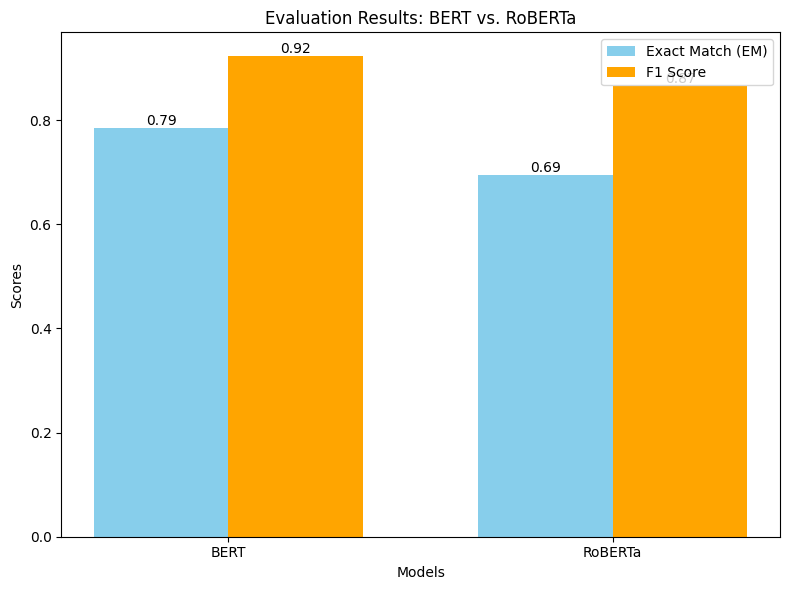

In [18]:
import matplotlib.pyplot as plt

# Add a function to plot the evaluation results
def plot_evaluation_results(bert_em, bert_f1, roberta_em, roberta_f1):
    models = ['BERT', 'RoBERTa']
    em_scores = [bert_em, roberta_em]
    f1_scores = [bert_f1, roberta_f1]

    x = np.arange(len(models))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))
    bars1 = ax.bar(x - width/2, em_scores, width, label='Exact Match (EM)', color='skyblue')
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='orange')

    # Add text for labels, title, and axes
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Evaluation Results: BERT vs. RoBERTa')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    # Attach numerical labels above bars
    for bar in bars1 + bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Plot the evaluation results
plot_evaluation_results(bert_em, bert_f1, roberta_em, roberta_f1)


Step 9. Gradio UI Interface

In [19]:
# Gradio UI Interface
def qa_interface(question, context, model_choice):
    if model_choice == 'BERT':
        answer = bert_qa(question=question, context=context)['answer']
    elif model_choice == 'RoBERTa':
        answer = roberta_qa(question=question, context=context)['answer']
    return answer

gr.Interface(
    fn=qa_interface, 
    inputs=[
        gr.Textbox(label="Ask a Question"),  
        gr.Textbox(label="Provide Context"),  
        gr.Dropdown(label="Select Model", choices=['BERT', 'RoBERTa'], value='BERT')  
    ],
    outputs="text",  
    live=True,  
    title="Question Answering with BERT and RoBERTa"
).launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://55cf7d6a6a35e11c8b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
